## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(134524)

# DP parameters
x_dim = 2
k_approx = 5
num_obs = 1000

# prior parameters
alpha = 1.2 # DP parameter
mu_prior = np.zeros(x_dim)
mu_prior_info = 1.0 * np.eye(x_dim)

info_x = 1.0 * np.eye(x_dim)

x, true_mu, true_z, true_z_ind, true_v, true_pi = \
            dp.draw_data(alpha, mu_prior, mu_prior_info, info_x, x_dim, k_approx, num_obs)

observed mixture proportions: 
 [ 0.75   0.033  0.049  0.015  0.153]
true mixture proportions: 
 [ 0.74617435  0.03679966  0.05712849  0.01393875  0.14595876]


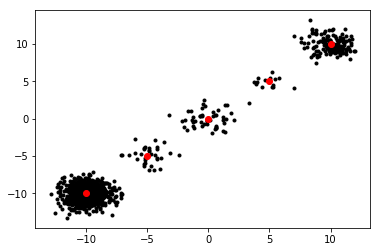

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_approx):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

In [4]:
def f(x): 
    return x * np.log(x)

H_f = hessian(f)

H_f(0.0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: invalid value encountered in multiply
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: invalid value encountered in true_divide
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: divide by zero encountered in true_divide
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_grads.py:41: RuntimeWarning: invalid value encountered in double_scalars
  anp.true_divide.defvjp(lambda g, ans, vs, gvs, x, y : unbroadcast(vs, gvs, - g * x / y**2), argnum=1)


array(nan)

## Set up VB model

In [5]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [6]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='mu_prior_mean', size=x_dim, val=mu_prior))
prior_params.push_param(PosDefMatrixParam(name='mu_prior_info', size=x_dim, val=mu_prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

## Initialize

In [7]:
## initialize VB params

true_init = True
if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    
    true_z_ = deepcopy(true_z)
    true_z_[true_z == 1] = .99
    true_z_[true_z == 0] = .01 / (k_approx - 1)
    
    vb_params['global']['mu'].set(true_mu)
    # vb_params['global']['mu'].set_free(np.random.random(vb_params['global']['mu'].free_size()))
    
    vb_params['global']['v_sticks'].alpha.set(true_tau)
    # vb_params['global']['v_sticks'].alpha.set_free(np.random.random(vb_params['global']['v_sticks'].free_size()))
    
    vb_params['local']['e_z'].set(true_z_)
    # vb_params['local']['e_z'].set_free(np.random.random(vb_params['local']['e_z'].free_size()))
    
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_par_vec = vb_params.get_free()
global_init_par_vec = vb_params['global'].get_free()

## Newton Optimization

In [8]:
model = dp.DPNormalMixture(x, vb_params, prior_params)
kl_obj = Objective(model.vb_params['global'], model.kl)

In [9]:
# check that the cavi update runs
model.optimize_z()

# check that the elbo computation runs
model.kl(verbose = True)

[[  1.43472949e-150   1.10385775e-081   5.46368456e-033   7.75093832e-007
    9.99999225e-001]
 [  9.99998549e-001   1.45053556e-006   1.35358897e-032   3.62027358e-081
    8.80587863e-150]
 [  1.00000000e+000   6.15481595e-016   2.43702262e-051   2.76566903e-109
    2.85441800e-187]
 ..., 
 [  9.99999999e-001   5.07449738e-010   1.65659171e-039   1.55000855e-091
    1.31895331e-163]
 [  1.00000000e+000   2.57217661e-011   4.25628782e-042   2.01863291e-095
    8.70683728e-169]
 [  9.99999999e-001   7.98211711e-010   4.09888383e-039   6.03266601e-091
    8.07476092e-163]]
ELBO:	 89174.7450946


-89174.745094616068

In [10]:
# check that gradient works
kl_obj.fun_free_grad(global_init_par_vec)

Autograd ArrayNode with value [[  1.43472949e-150   1.10385775e-081   5.46368456e-033   7.75093832e-007
    9.99999225e-001]
 [  9.99998549e-001   1.45053556e-006   1.35358897e-032   3.62027358e-081
    8.80587863e-150]
 [  1.00000000e+000   6.15481595e-016   2.43702262e-051   2.76566903e-109
    2.85441800e-187]
 ..., 
 [  9.99999999e-001   5.07449738e-010   1.65659171e-039   1.55000855e-091
    1.31895331e-163]
 [  1.00000000e+000   2.57217661e-011   4.25628782e-042   2.01863291e-095
    8.70683728e-169]
 [  9.99999999e-001   7.98211711e-010   4.09888383e-039   6.03266601e-091
    8.07476092e-163]] and 1 progenitors(s)


array([  7.49999753e+02,   0.00000000e+00,   7.49999753e+02,
         3.30001454e+01,   0.00000000e+00,   3.30001454e+01,
         4.93827695e+01,   0.00000000e+00,   4.93827695e+01,
         1.46174823e+01,   0.00000000e+00,   1.46174823e+01,
         1.52999850e+02,   0.00000000e+00,   1.52999850e+02,
        -2.36350361e+01,  -1.11682276e+01,  -8.46915481e+00,
        -8.32281277e+00,   5.04775696e+00,   1.54894098e+00,
         6.89709389e+00,   7.67811754e+00,   7.68716601e+00,
         1.36798180e+01,  -4.35918760e+00,  -1.74038322e-01,
         1.98653175e+00,  -2.69004237e+00,   7.01264181e+00,
        -7.52602269e+00,  -1.19433235e+00,   7.87826763e-01])

In [12]:
# check that hessian works
H = kl_obj.fun_free_hessian(global_init_par_vec)
print(np.shape(H))
print(H)

Autograd ArrayNode with value [[  1.43472949e-150   1.10385775e-081   5.46368456e-033   7.75093832e-007
    9.99999225e-001]
 [  9.99998549e-001   1.45053556e-006   1.35358897e-032   3.62027358e-081
    8.80587863e-150]
 [  1.00000000e+000   6.15481595e-016   2.43702262e-051   2.76566903e-109
    2.85441800e-187]
 ..., 
 [  9.99999999e-001   5.07449738e-010   1.65659171e-039   1.55000855e-091
    1.31895331e-163]
 [  1.00000000e+000   2.57217661e-011   4.25628782e-042   2.01863291e-095
    8.70683728e-169]
 [  9.99999999e-001   7.98211711e-010   4.09888383e-039   6.03266601e-091
    8.07476092e-163]] and 2 progenitors(s)


/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_grads.py:41: RuntimeWarning: invalid value encountered in true_divide
  anp.true_divide.defvjp(lambda g, ans, vs, gvs, x, y : unbroadcast(vs, gvs, - g * x / y**2), argnum=1)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_grads.py:41: RuntimeWarning: divide by zero encountered in true_divide
  anp.true_divide.defvjp(lambda g, ans, vs, gvs, x, y : unbroadcast(vs, gvs, - g * x / y**2), argnum=1)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:213: RuntimeWarning: invalid value encountered in add
  x += y


(33, 33)
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


1.1485226699906812e+168

In [64]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8, 'disp': True})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:84: RuntimeWarning: overflow encountered in power
  result_value = self.fun(*argvals, **kwargs)
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_grads.py:48: RuntimeWarning: invalid value encountered in multiply
  unbroadcast(vs, gvs, g * y * x ** anp.where(y, y - 1, 1.)))
/home/runjing_liu/anaconda3/lib/python3.6/site-packages/autograd/core.py:213: RuntimeWarning: invalid value encountered in add
  x += y


ValueError: array must not contain infs or NaNs

In [ ]:
model.vb_params['global'].set_free(vb_opt.x)

In [ ]:
model.vb_params['global']['mu'].get()

In [ ]:
true_mu